In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import levene
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [2]:
path = '/Users/dingxuzhou/Downloads'
hospital_df = pd.read_csv(path + '/joined_data.csv', dtype={'GEOID': str})
hospital_df.loc[:,'GEOID'] = hospital_df['GEOID'].apply(lambda x: x.zfill(5))
hospital_df = hospital_df[(hospital_df['Year'] >= 2011) & (hospital_df['Year'] <= 2020)]
# Modify columns
hospital_df.loc[:, 'Net Household Outflow'] = hospital_df['Outflow_Household'] - hospital_df['Inflow_Household']
hospital_df.loc[:, 'Net Individual Outflow'] = hospital_df['Outflow_Individual'] - hospital_df['Inflow_Individual']
hospital_df.loc[:, 'Net AGI Outflow'] = hospital_df['Outflow_AGI'] - hospital_df['Inflow_AGI']
hospital_df.loc[:, 'Ruca Rural Percentage'] = hospital_df['RucaRural']/(hospital_df['RucaRural'] + hospital_df['RucaSuburban'] + hospital_df['RucaUrban'])
hospital_df = hospital_df.drop(columns=['Outflow_Household', 'Inflow_Household', 'Outflow_Individual',
                                        'Inflow_Individual', 'Outflow_AGI', 'Inflow_AGI',
                                          'RucaRural', 'RucaSuburban', 'RucaUrban'])

In [3]:
filter_df = hospital_df[hospital_df['HasClosed'] != 0]
filter_df = filter_df.sort_values(by=['HID', 'Year']) 
filter_df = filter_df.drop_duplicates(subset='HID', keep='last')
filter_df.reset_index(drop=True, inplace=True)

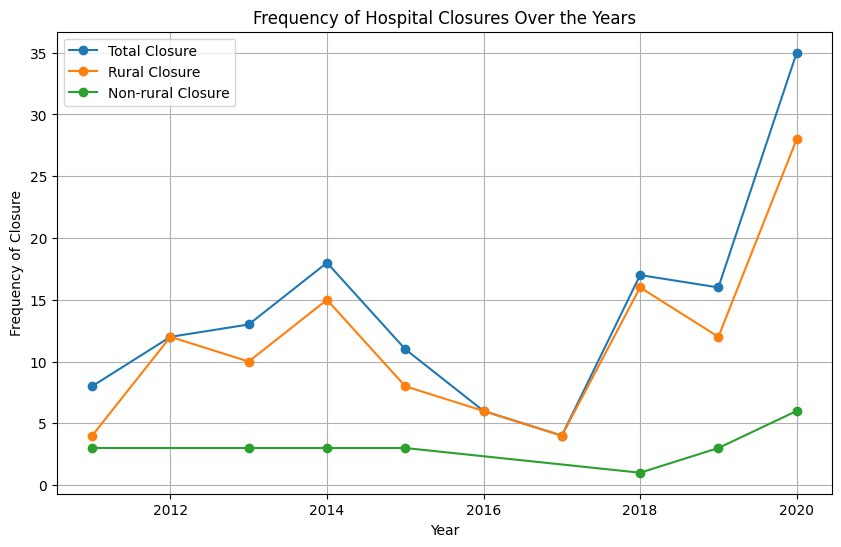

In [4]:
rural_closure = filter_df[filter_df['CdcRurality'] > 3].groupby('Year').size().reset_index(name='Rural Closure')
non_rural_closure = filter_df[filter_df['CdcRurality'] < 4].groupby('Year').size().reset_index(name='Non-rural Closure')
all_closure = filter_df.groupby('Year').size().reset_index(name='Total Closure')

plt.figure(figsize=(10, 6))
plt.plot(all_closure['Year'], all_closure['Total Closure'], marker='o', linestyle='-')
plt.plot(rural_closure['Year'], rural_closure['Rural Closure'], marker='o', linestyle='-')
plt.plot(non_rural_closure['Year'], non_rural_closure['Non-rural Closure'], marker='o', linestyle='-')
plt.title('Frequency of Hospital Closures Over the Years')
plt.xlabel('Year')
plt.ylabel('Frequency of Closure')
plt.legend(['Total Closure', 'Rural Closure', 'Non-rural Closure'])
plt.grid(True)
plt.show()


In [5]:
def plot_graph(df, col_name):
    # Create a figure and two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    rural_df = df[df['CdcRurality'] > 3]
    non_rural_df = df[df['CdcRurality'] < 4]

    # Remove outliers using Z-score method
    z_scores_nonrural = np.abs(stats.zscore(non_rural_df[col_name]))
    filter_non_rural_df = non_rural_df[(z_scores_nonrural < 3)]  # Keep only data points within 3 standard deviations
    z_scores_rural = np.abs(stats.zscore(rural_df[col_name]))
    filter_rural_df = rural_df[(z_scores_rural < 3)]  # Keep only data points within 3 standard deviations

    # Find the median and mean population for non-rural counties after removing outliers
    median_nonrural = non_rural_df[col_name].median()
    mean_nonrural = non_rural_df[col_name].mean()

    # Find the median and mean population for rural counties after removing outliers
    median_rural = rural_df[col_name].median()
    mean_rural = rural_df[col_name].mean()

    # Plot non-rural population on the first subplot
    ax1.plot(filter_non_rural_df[col_name].values, label='Non-rural', color='blue')
    ax1.axhline(y=median_nonrural, color='red', linestyle='--', label='Median')
    ax1.axhline(y=mean_nonrural, color='green', linestyle='--', label='Mean')
    ax1.set_xlabel('Data Points')
    ax1.set_ylabel(col_name)
    ax1.legend()

    # Plot rural population on the second subplot
    ax2.plot(filter_rural_df[col_name].values, label='Rural', color='red')
    ax2.axhline(y=median_rural, color='blue', linestyle='--', label='Median')
    ax2.axhline(y=mean_rural, color='green', linestyle='--', label='Mean')
    ax2.set_xlabel('Data Points')
    ax2.set_ylabel(col_name)
    ax2.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plots
    plt.show()


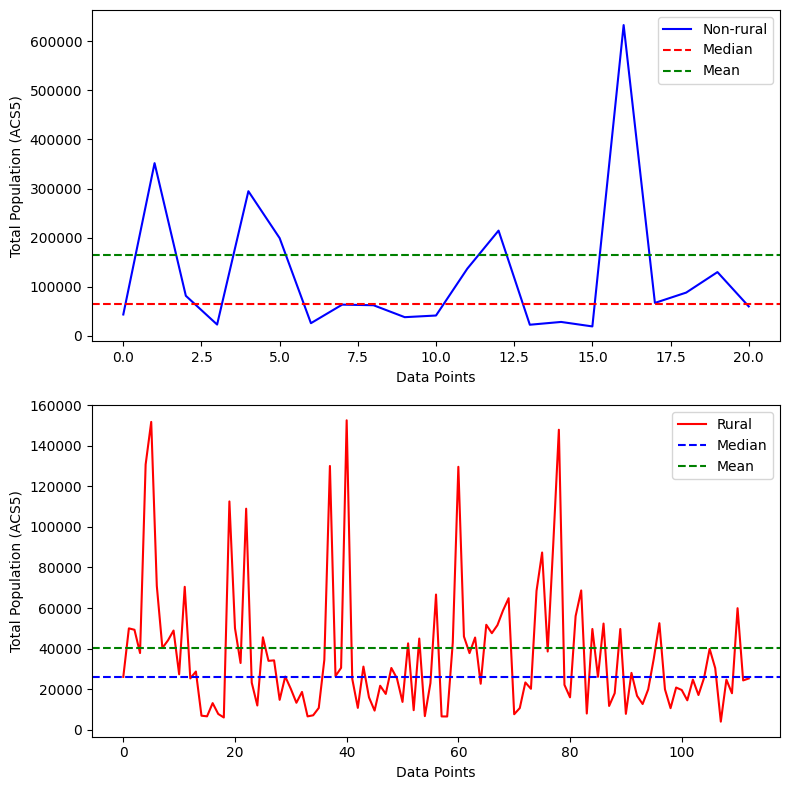

In [6]:
plot_graph(filter_df, 'Total Population (ACS5)')

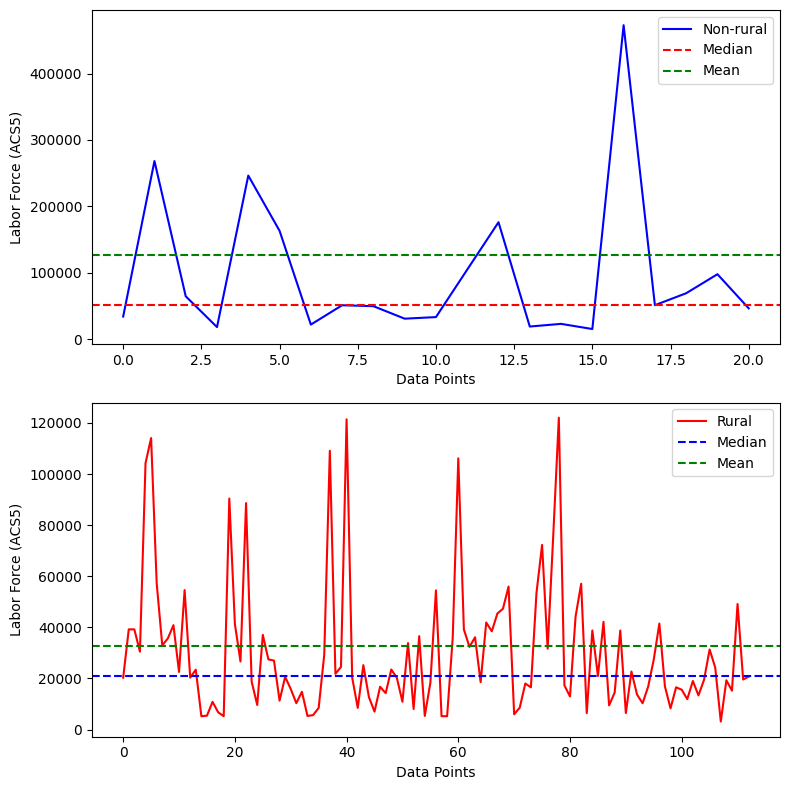

In [7]:
plot_graph(filter_df, 'Labor Force (ACS5)')

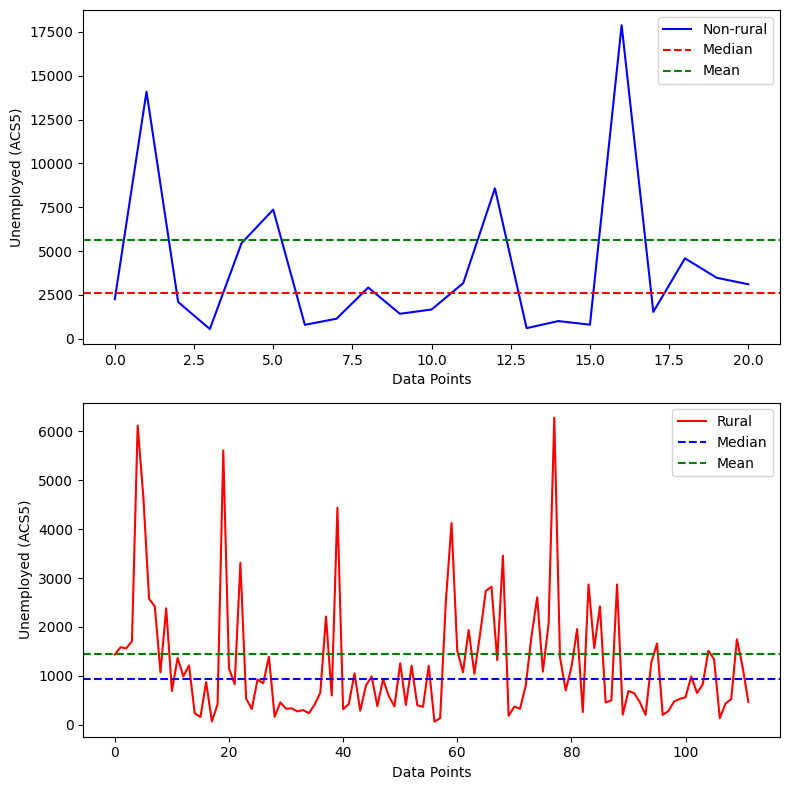

In [8]:
plot_graph(filter_df, 'Unemployed (ACS5)')

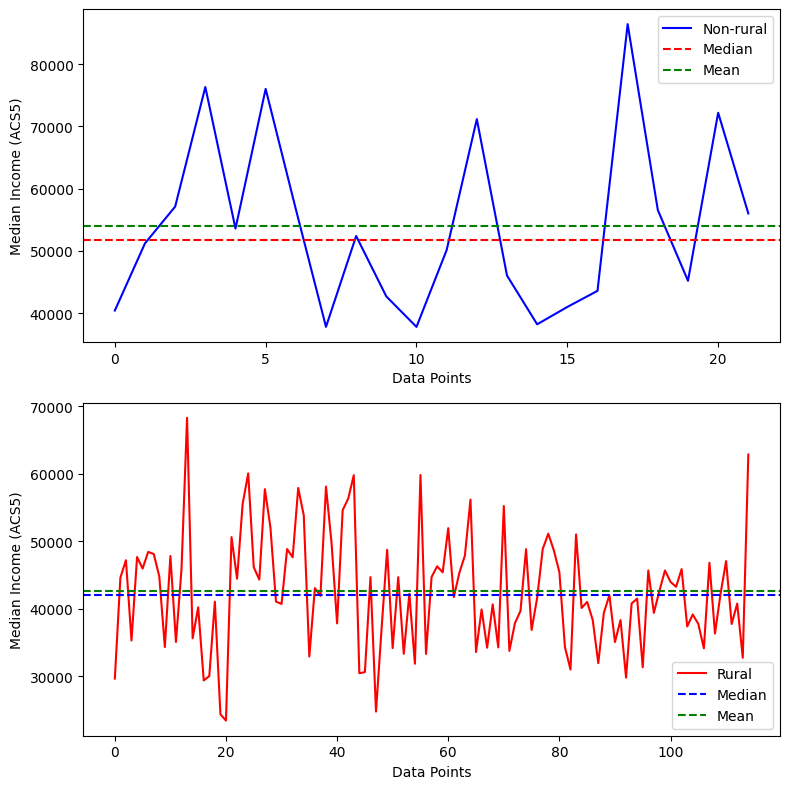

In [9]:
plot_graph(filter_df, 'Median Income (ACS5)')

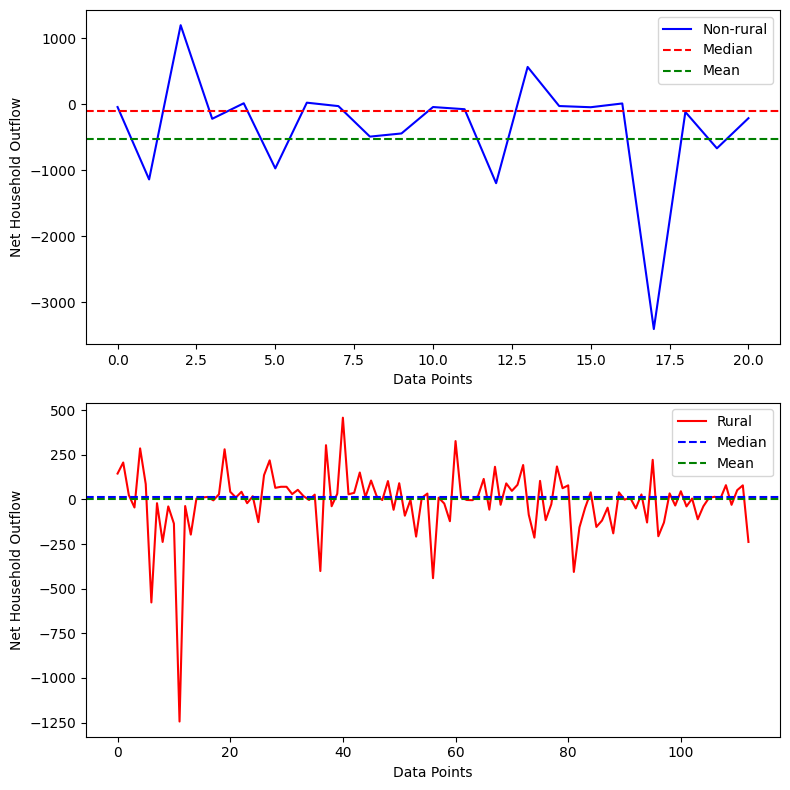

In [10]:
plot_graph(filter_df, 'Net Household Outflow')

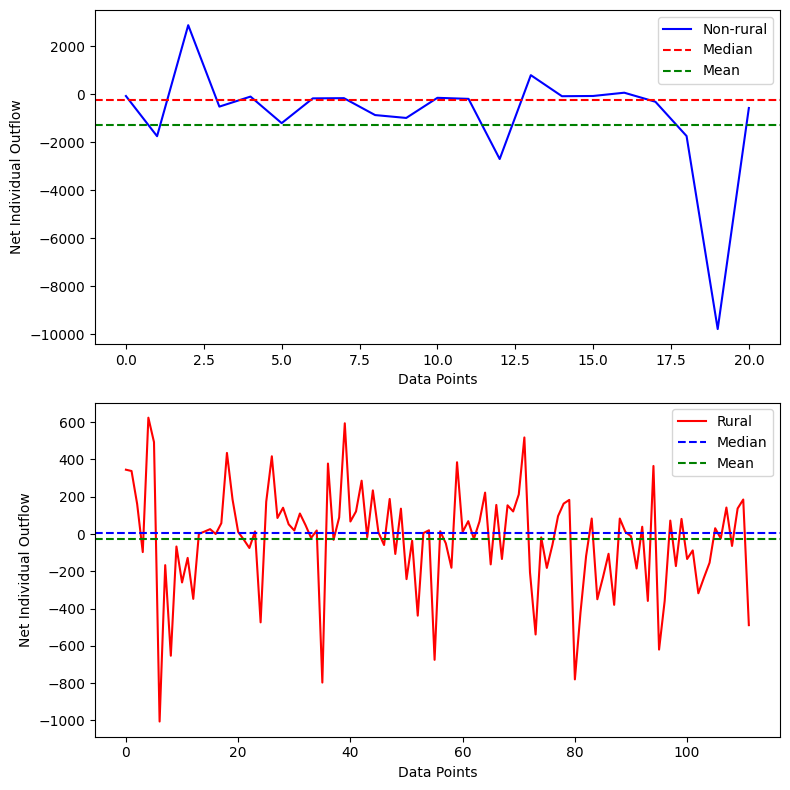

In [11]:
plot_graph(filter_df, 'Net Individual Outflow')

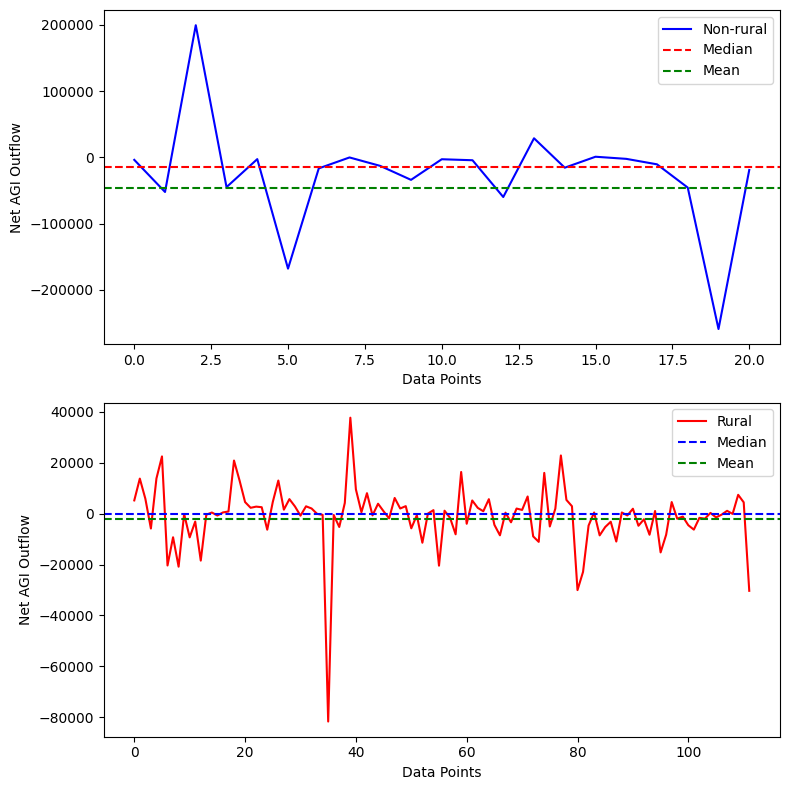

In [12]:
plot_graph(filter_df, 'Net AGI Outflow')

In [14]:
# Drop columns that are not needed for OLS
OLS_df = hospital_df.copy()
OLS_df.drop(columns=['Name', 'Address', 'City', 'State', 'Zip', 
                  'Total Population (ACS1)', 'Labor Force (ACS1)', 'Unemployed (ACS1)', 
                  'Median Income (ACS1)', 'Labor Force (ACSSE)', 'Unemployed (ACSSE)', 
                  'Median Income (ACSSE)', 'Total Population (ACSSE)','ClosureMonth', 'Converted', 
                  'HospitalType', 'GEOID', 'Medicare Payment', '# of Beds', 'HasEmergencyServices', 
                  'HasBirthingFriendlyDesignation'], inplace=True)

In [28]:
# Step 1: Group the DataFrame by hospital identifier (HID)
grouped = OLS_df.groupby('HID')

# Step 2: Initialize an empty list to store filtered DataFrames
filtered_groups = []

# Step 3: Handle special cases for each group
for _, group in grouped:
    if group['HasClosed'].any() != 0:  # If hospital has closed
        closure_year = group.loc[group['HasClosed'] != 0, 'ClosureYear'].values[0]
        rows_for_calculation = group[(group['Year'] == closure_year) | (group['Year'] == closure_year - 1)]
    else:  # If hospital has not closed
        latest_year = group['Year'].max()
        rows_for_calculation = group[(group['Year'] == latest_year) | (group['Year'] == latest_year - 1)]
    
    if not rows_for_calculation.empty:
        # Exclude columns you don't want to difference
        exclude_columns = ['HID', 'Year', 'HasClosed', 'ClosureYear', 'FarP', 'CdcRurality', 'Ruca Rural Percentage']
        
        # Calculate differences for all other columns
        columns_for_calculation = [col for col in rows_for_calculation.columns if col not in exclude_columns]
        differences = rows_for_calculation[columns_for_calculation].diff()
        
        # Concatenate selected columns with the rest of the columns from the latest year
        latest_year_data = rows_for_calculation.drop(columns=columns_for_calculation)
        combined_data = pd.concat([latest_year_data, differences], axis=1)
        
        # Append the combined data to the list
        filtered_groups.append(combined_data)

# Step 4: Concatenate the filtered DataFrames into a single DataFrame
if filtered_groups:
    modified_df = pd.concat(filtered_groups)
else:
    modified_df = pd.DataFrame()

In [29]:
modified_df.dropna(how='all', inplace=True)
modified_df.fillna(0, inplace=True)
modified_df.reset_index(drop=True, inplace=True)
modified_df.drop(columns=['ClosureYear', 'HID', 'Year'], inplace=True)

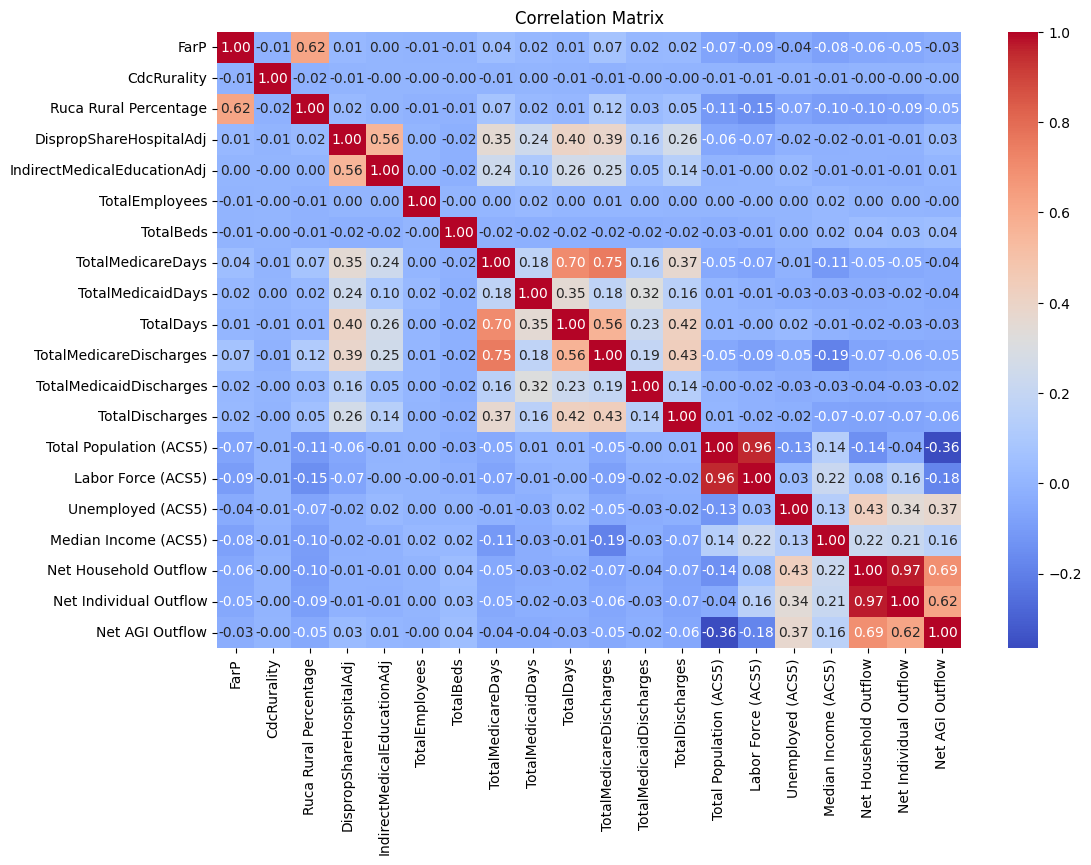

In [30]:
# Check for correlation among independent variables
correlation_matrix = modified_df.drop(columns=['HasClosed']).corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [34]:
# Find variables with high correlation
highly_correlated_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Adjust the threshold as needed
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_vars.add(colname_i)
            highly_correlated_vars.add(colname_j)

# Drop highly correlated variables
modified_df_filter = modified_df.drop(columns=highly_correlated_vars)

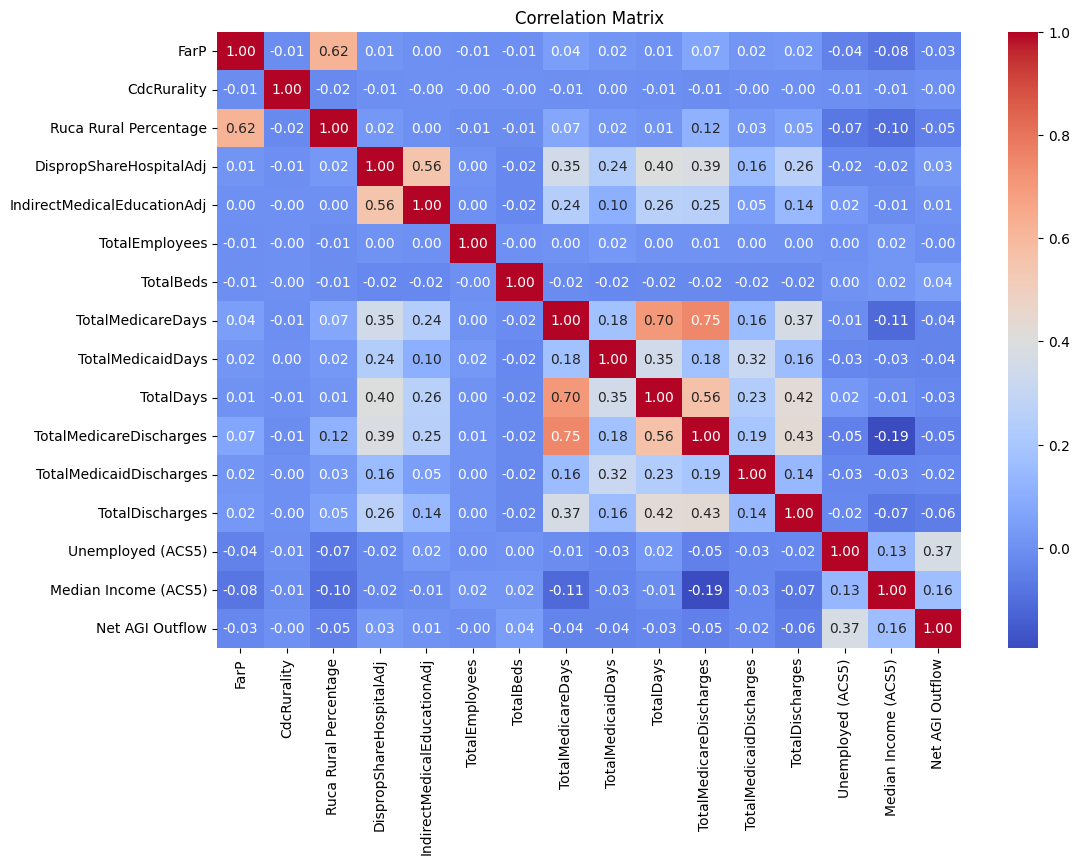

In [35]:
# Check for correlation among independent variables
correlation_matrix_filter = modified_df_filter.drop(columns=['HasClosed']).corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filter, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [37]:
# Define independent variables (features)
X = modified_df_filter.drop(columns=['HasClosed'])

# Add constant term to independent variables
X = sm.add_constant(X)

# Define dependent variable
y = modified_df_filter['HasClosed']

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print model summary
result.summary()


Optimization terminated successfully.
         Current function value: 0.064668
         Iterations 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              HasClosed   No. Observations:                13481
Model:                          Logit   Df Residuals:                    13464
Method:                           MLE   Df Model:                           16
Date:                Fri, 23 Feb 2024   Pseudo R-squ.:                 0.07527
Time:                        20:54:12   Log-Likelihood:                -871.80
converged:                       True   LL-Null:                       -942.75
Covariance Type:            nonrobust   LLR p-value:                 3.034e-22
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -4.8371      0.128    -37.814      0.000      -5.088      -4.586
FarP                           -0.0147      0.003     -5.093      0.000      -0.020      -0.009
CdcRurality                 -1.317e-05      0.000     -0.078      0.938      -0.000       0.000
Ruca Rural Percentage           2.1704      0.201     10.798      0.000       1.776       2.564
DispropShareHospitalAdj     -4.174e-07   5.02e-07     -0.831      0.406    -1.4e-06    5.67e-07
IndirectMedicalEducationAdj  3.528e-08   1.76e-07      0.200      0.841    -3.1e-07     3.8e-07
TotalEmployees                 -0.0002      0.001     -0.322      0.747      -0.002       0.001
TotalBeds                    7.663e-06   5.74e-05      0.133      0.894      -0.000       0.000
TotalMedicareDays              -0.0002      0.000     -1.863      0.062      -0.000    1.07e-05
TotalMedicaidDays           -2.092e-05   8.86e-05     -0.236      0.813      -0.000       0.000
TotalDays                    3.154e-05   2.51e-05      1.256      0.209   -1.77e-05    8.08e-05
TotalMedicareDischarges         0.0010      0.001      1.737      0.082      -0.000       0.002
TotalMedicaidDischarges        -0.0002      0.000     -0.583      0.560      -0.001       0.001
TotalDischarges             -1.501e-05   3.95e-05     -0.380      0.704   -9.25e-05    6.24e-05
Unemployed (ACS5)           -3.071e-05   3.34e-05     -0.921      0.357   -9.61e-05    3.47e-05
Median Income (ACS5)           -0.0002   4.41e-05     -4.371      0.000      -0.000      -0.000
Net AGI Outflow             -8.046e-08   2.75e-07     -0.293      0.770   -6.19e-07    4.59e-07
===============================================================================================
"""

Naive Bayes Classifier (NB):
Naive Bayes is a probabilistic machine learning algorithm based on Bayes' Theorem. It is called "naive" because it assumes that the features in the dataset are independent of each other, which might not be true in real-world scenarios. Despite this simplification, Naive Bayes classifiers perform remarkably well in many cases, especially in text classification and spam filtering.

Explanation:

Bayes' Theorem: It calculates the probability of a hypothesis (class) given the data.
P(H|D) = P(D|H) * P(H) / P(D)
Where:
P(H|D): Probability of hypothesis given the data (posterior).
P(D|H): Probability of data given the hypothesis (likelihood).
P(H): Probability of hypothesis (prior).
P(D): Probability of data (evidence).
Naive Assumption: It assumes that the features are conditionally independent given the class label.
P(x₁, x₂, ..., xₙ | C) = P(x₁ | C) * P(x₂ | C) * ... * P(xₙ | C)
Classification: Given a new instance, the classifier calculates the probability of each class and assigns the class with the highest probability.
Example Graph:
Below is a simplified graphical representation of a Naive Bayes classifier for binary classification:

Support Vector Machine (SVM):
SVM is a powerful supervised learning algorithm used for classification and regression tasks. It works by finding the hyperplane that best separates the classes in feature space. SVM aims to maximize the margin between the classes, making it robust to overfitting.

Explanation:

Hyperplane: It is a decision boundary that separates the classes in feature space.
Margin: The distance between the hyperplane and the nearest data point from either class.
Support Vectors: Data points that are closest to the hyperplane and influence its position.
Kernel Trick: SVM can handle non-linear decision boundaries by transforming the input space into a higher-dimensional space using kernel functions.
Example Graph:
Below is a simple visualization of SVM with a linear kernel for binary classification:

In this graph:

The circles and squares represent two different classes.
The solid line represents the decision boundary (hyperplane).
The dashed lines represent the margins, which are equidistant from the decision boundary and pass through the support vectors.
These visualizations provide a basic understanding of how Naive Bayes and SVM work and how they make decisions based on input features. They serve as a foundation for understanding more complex scenarios and variations of these algorithms.

In [39]:
# Assuming modified_df contains your data
X = modified_df.drop(columns=['HasClosed'])

# Binary label
y = modified_df['HasClosed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)

# Evaluate the performance
print("Naive Bayes Classifier:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:")
print(classification_report(y_test, nb_predictions))



In [ ]:
# SVM Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

print("\nSVM Classifier:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Classification Report:")
print(classification_report(y_test, svm_predictions))